<a href="https://www.kaggle.com/code/rumitpathare/custom-mobilenetv2-u-net-model-optimised?scriptVersionId=142510263" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Custom U-Net model

Using a custom u-net model to extract the required features from dataset to draw out accurate masking image. My idea is to create a modified encoder insipired by mobile-net V2 as it is light weight and will be faster yet accurate to extract required features from data. As for decoding part is will be similar to u-net with some minor changes to optimize the outcome.

## 1. Importing Libraries

> In this section, we are importing various Python libraries that will be utilized throughout the code. These libraries provide powerful tools and functions for tasks such as:

- Image processing
- Data manipulation
- Visualization
- Deep learning

In [1]:
pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.3 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch.summary

Note: you may need to restart the kernel to use updated packages.


In [3]:
import zipfile
from PIL import Image
import io
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import tensor
from torchinfo import summary
import torch.nn.functional as F


## 2. Listing Files in a Directory

> In this code segment, we are working with the `os` library to interact with the file system and list files within a specified directory. The purpose of this code is to traverse through a directory and its subdirectories, printing out the paths of all the files encountered.

In [4]:
import os
directory = r'/kaggle/input'
for dirname, _, filenames in os.walk(directory):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/carvana-image-masking-challenge/train_masks.zip
/kaggle/input/carvana-image-masking-challenge/29bb3ece3180_11.jpg
/kaggle/input/carvana-image-masking-challenge/train_masks.csv.zip
/kaggle/input/carvana-image-masking-challenge/train.zip
/kaggle/input/carvana-image-masking-challenge/metadata.csv.zip
/kaggle/input/carvana-image-masking-challenge/sample_submission.csv.zip
/kaggle/input/carvana-image-masking-challenge/test.zip
/kaggle/input/carvana-image-masking-challenge/test_hq.zip
/kaggle/input/carvana-image-masking-challenge/train_hq.zip
/kaggle/input/nodata/MobileNetV2_Unet_wts.pth


> Contained within the ZIP file are images that pique our curiosity. Let's unveil the contents within and embrace the anticipation of discovering the intriguing data that lies in wait.

## 3. Visualize the Data

> This code snippet illustrates the process of extracting and displaying image and CSV data from either ZIP archives or standalone image files within the specified directory. Images are displayed in a layout, while CSV data is read and printed. The code showcases efficient handling of diverse data formats.

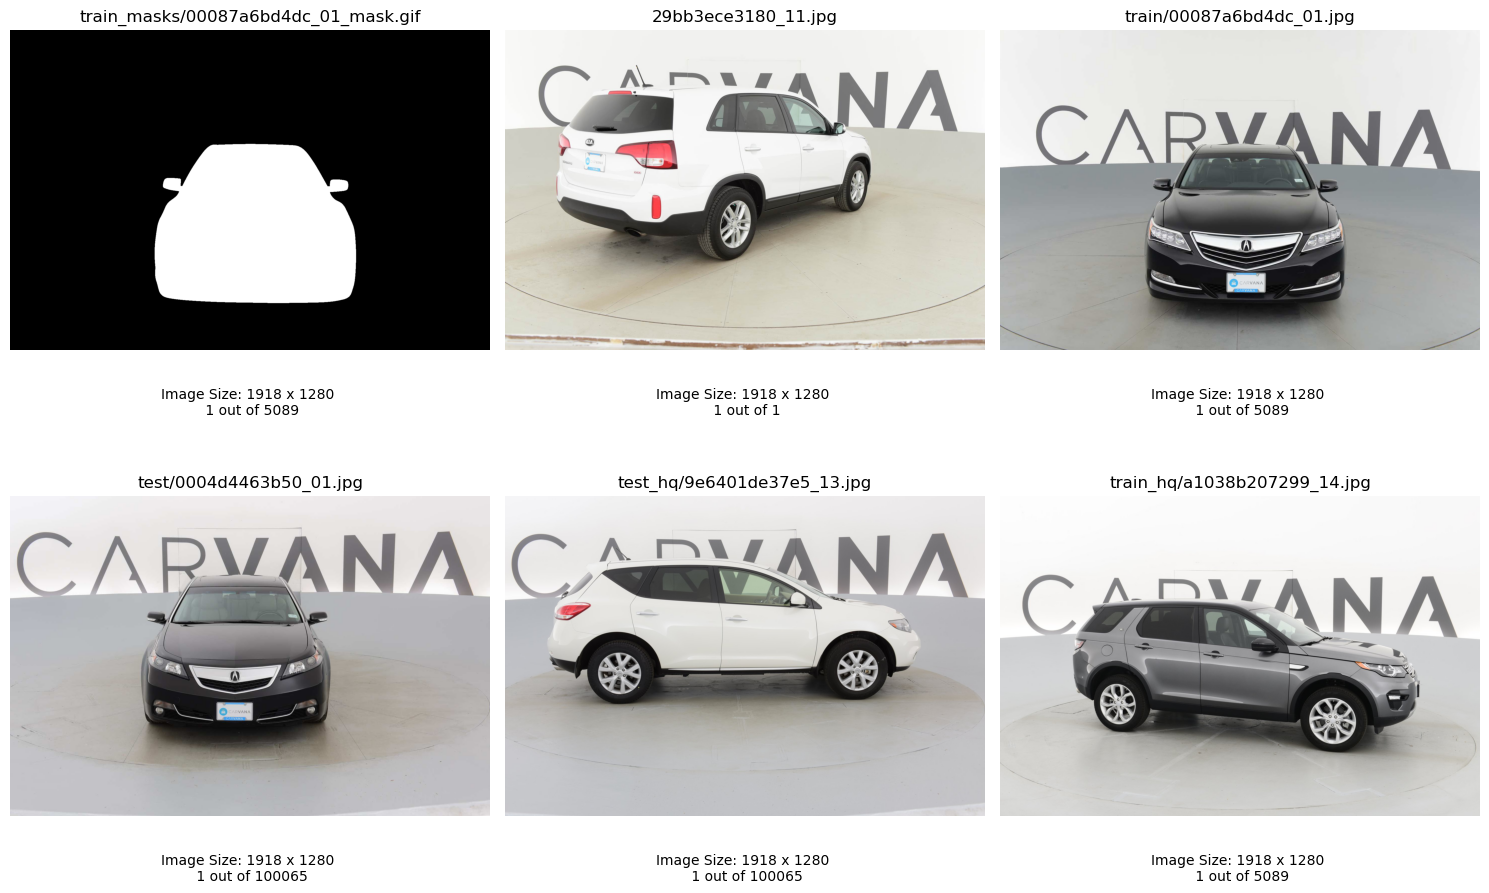


 ----- train_masks.csv ----- 

                   img                                           rle_mask
0  00087a6bd4dc_01.jpg  879386 40 881253 141 883140 205 885009 17 8850...
1  00087a6bd4dc_02.jpg  873779 4 875695 7 877612 9 879528 12 881267 15...
2  00087a6bd4dc_03.jpg  864300 9 866217 13 868134 15 870051 16 871969 ...
3  00087a6bd4dc_04.jpg  879735 20 881650 26 883315 92 883564 30 885208...
4  00087a6bd4dc_05.jpg  883365 74 883638 28 885262 119 885550 34 88716...
Data Size: 5088

 ----- metadata.csv ----- 

             id    year       make   model   trim1                    trim2
0  0004d4463b50  2014.0      Acura      TL      TL                     w/SE
1  00087a6bd4dc  2014.0      Acura     RLX     RLX                   w/Tech
2  000aa097d423  2012.0      Mazda  MAZDA6  MAZDA6                  i Sport
3  000f19f6e7d4  2016.0  Chevrolet  Camaro  Camaro                       SS
4  00144e887ae9  2015.0      Acura     TLX     TLX  SH-AWD V6 w/Advance Pkg
Data Size: 6572

 -----

In [5]:
image_list = []  
csv_list = []

for dirname, _, filenames in os.walk(directory):
    for filename in filenames:
        if filename.endswith(".pth"):
            pass
        elif filename.endswith(".zip"):
            zipfile_path = os.path.join(dirname, filename)
            with zipfile.ZipFile(zipfile_path, 'r') as zip_ref:
                file_list = zip_ref.infolist()
                #print("No. of files inside ",filename," - ",len(file_list))
                for item in file_list:
                    if item.filename.lower().endswith((".jpg", ".jpeg", ".png", ".gif")):
                        #print("-----",item.filename,"-----")
                        image_data = zip_ref.read(item.filename)
                        img = Image.open(io.BytesIO(image_data))
                        #print(img.size)
                        length = len(file_list)
                        image_list.append((item.filename, img, length))
                        #plt.imshow(img)
                        #plt.title(item.filename)
                        #plt.axis('off')
                        #plt.show()
                        break
                        
                    elif item.filename.lower().endswith(".csv"):
                        #print("-----",item.filename,"-----")
                        csv_data_bytes = zip_ref.read(item.filename)
                        csv_data_text = csv_data_bytes.decode("utf-8")
                        csv_file_obj = io.StringIO(csv_data_text)
                        df = pd.read_csv(csv_file_obj)
                        #print(df.head())
                        csv_list.append((item.filename, csv_data_text))
                        break
                            
        else:
            zipfile_path = os.path.join(dirname, filename)
            image = Image.open(zipfile_path)
            image_list.append((filename, image, 1))
            #plt.imshow(image)
            #plt.title(filename)
            #plt.axis('off')
            #plt.show()
            
num_rows = 2 
num_cols = (len(image_list) + 1) // num_rows

plt.figure(figsize=(15, 10))

for i, (img_filename, img, length) in enumerate(image_list, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.imshow(img)
    plt.title(img_filename)
    plt.axis('off')
    img_size = img.size
    plt.annotate(f"Image Size: {img_size[0]} x {img_size[1]} \n 1 out of {length}", xy=(0.5, -0.2), ha='center', fontsize=10, xycoords='axes fraction')

plt.tight_layout()
plt.show()

# Display CSV data
for csv_filename, csv_data_text in csv_list:
    print("\n -----", csv_filename, "----- \n")
    csv_file_obj = io.StringIO(csv_data_text)
    df = pd.read_csv(csv_file_obj)
    print(df.head())
    print(f"Data Size: {len(df)}")

> Examining the contents within the ZIP archives, we find a wealth of data, yet our focus narrows to "train.zip" and "train_mask.zip." These specific archives contain corresponding images, forming a valuable set for training. Our intent is to extract and store these ZIP files on the hard drive. This approach optimizes memory usage, as loading images directly from the ZIP files diminishes strain on RAM and GPU resources.

## 4. Selective Extraction of Training Data
> This code segment focuses on extracting specific ZIP files, namely "train.zip" and "train_masks.zip," from the given directory. Extracted contents are placed at the specified extract_path, optimizing access and facilitating data usage without overloading memory resources.

In [6]:
extract_path = '/kaggle/working/'  # Replace this with the path where you want to extract the contents

for dirname, _, filenames in os.walk(directory):
    for filename in filenames:
        if filename in ["train.zip", "train_masks.zip"]:
            print(filename)
            zipfile_path = os.path.join(dirname, filename)
            with zipfile.ZipFile(zipfile_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
                print("Extraction complete.")

train_masks.zip
Extraction complete.
train.zip
Extraction complete.


## 5. Visualizing Paired Data

> The code's purpose is to create a visualization that pairs original images with their corresponding masks. This enables a quick and clear understanding of how masks align with their respective images, aiding in data comprehension and analysis for potential applications like image segmentation tasks.

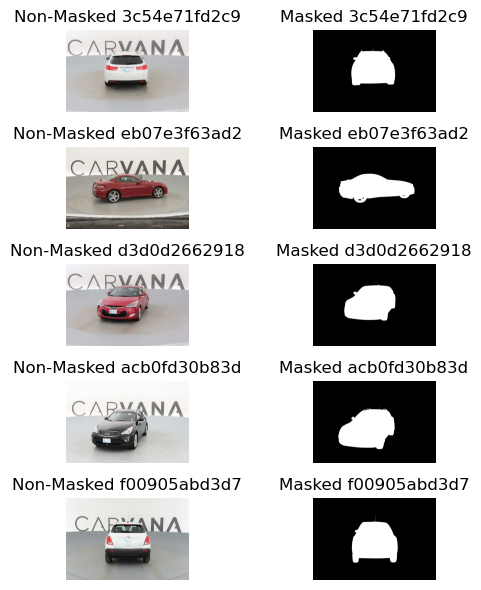

In [7]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(6, 6))
for root, dirs, filenames in os.walk(extract_path):
    c = 0
    for filename in filenames:
        if c >= 5:
            break
        if 'train_masks' in root:
            
            image_path = os.path.join(root.replace('train_masks', 'train'), filename.split("_")[0]+"_"+filename.split("_")[1]+".jpg")
            mask_path = os.path.join(root, filename)
            
            img = Image.open(image_path)
            img_mask = Image.open(mask_path)
            
            axes[c][0].imshow(img)
            axes[c][0].set_title(f"Non-Masked {filename.split('_')[0]}")
            axes[c][0].axis('off')
            
            axes[c][1].imshow(img_mask)
            axes[c][1].set_title(f"Masked {filename.split('_')[0]}")
            axes[c][1].axis('off')
            
            c += 1

plt.tight_layout()
plt.show()


> The data appears suitable for loading into the data loader to commence training.Data looks quite fine to load into the data loader to train it.

## 6. Custom Dataset Class for Paired Images

> This custom dataset class serves as a foundation for efficiently loading paired image data for training and other deep learning tasks. It offers flexibility in handling different types of image data and their relationships.

In [8]:
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms


preprocess_X = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0,0,0),std=(1,1,1))])

preprocess_y = transforms.Compose([
            transforms.Resize((258, 258)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0),std=(1))])

class CustomDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform_X=None, transform_y=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform_X = transform_X
        self.transform_y = transform_y

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        mask = Image.open(self.mask_paths[idx])
        
        if self.transform_X:
            image = self.transform_X(image)
        if self.transform_y:
            mask = self.transform_y(mask)
        
        return image, mask

### 6.1 Dataset Preparation with Image Preprocessing and Progress Tracking

> This code efficiently processes paired images and their corresponding masks, applying resizing and transformations. The tqdm library is utilized for progress visualization. The prepared dataset is encapsulated using a custom class for streamlined usage.

In [9]:
from tqdm import tqdm

train_img_X = []
train_img_y = []

for root, dirs, filenames in os.walk(extract_path):
    for filename in tqdm(filenames, desc="Processing images"):
        if 'train_masks' in root:
            image_path = os.path.join(root.replace('train_masks', 'train'), filename.split("_")[0] + "_" + filename.split("_")[1] + ".jpg")
            mask_path = os.path.join(root, filename)
            
            train_img_X.append(image_path)
            train_img_y.append(mask_path)

dataset = CustomDataset(train_img_X, train_img_y, transform_X=preprocess_X, transform_y=preprocess_y)
print("Dataset processing complete.")

Processing images: 0it [00:00, ?it/s]
Processing images: 100%|██████████| 5088/5088 [00:00<00:00, 1216405.54it/s]
Processing images: 0it [00:00, ?it/s]

Dataset processing complete.


## 7. Dataset for Training and Testing

> This section of code divides the dataset into training and testing subsets. It calculates the sizes for both subsets and creates two subsets using the `Subset` class. The training subset contains 90% of the data, while the testing subset holds the remaining 10%. This partitioning allows for effective model training and subsequent evaluation.

In [10]:
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size  

train_subset = Subset(dataset, range(train_size))
test_subset = Subset(dataset, range(train_size, len(dataset)))

### 7.1 Data Loading and Batching for Model Training

> This code snippet focuses on loading data for training and testing. It creates data loaders using the `DataLoader` class, ensuring efficient handling of batches during model training. The batch size is set to 16 for both loaders. The snippet showcases the data loader structure and the shapes of input images and output masks, demonstrating the successful configuration of data inputs for training and subsequent usage.

In [11]:
batch_size = 4

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [12]:
train_X_batch, train_y_batch = next(iter(train_loader))
print(train_X_batch.shape, train_y_batch.shape)
print(f"Length of train dataloader: {len(train_loader)}")

torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 258, 258])
Length of train dataloader: 1145


In [13]:
for batch in train_loader:
    image_x_batch, image_y_batch = batch
    break
    
print("Input Image shape: ",image_x_batch.shape)
print("Output Mask shape: ",image_y_batch.shape)

Input Image shape:  torch.Size([4, 3, 512, 512])
Output Mask shape:  torch.Size([4, 1, 258, 258])


### 7.2 Image and Mask Visualization

> This part of the code focuses on visualizing a randomly selected pair of images and their corresponding masks from the training dataset. It demonstrates the actual content of the data. 

Image size: torch.Size([3, 512, 512])
Masked image size: torch.Size([1, 258, 258])


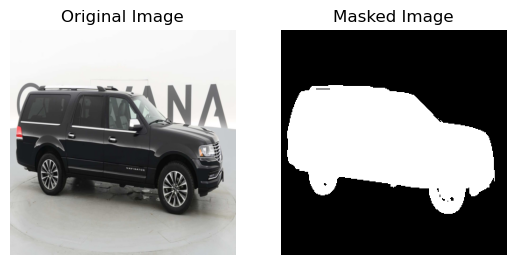

In [14]:
random_idx = torch.randint(0, len(train_X_batch), size=[1]).item()
#print(random_idx)
img_X, img_y = train_X_batch[random_idx], train_y_batch[random_idx]
fig,axes = plt.subplots(1, 2)
img_array = img_X.permute(1, 2, 0).cpu().numpy()
axes[0].imshow(img_array)
axes[0].set_title('Original Image')
axes[0].axis("Off")
mask_array = img_y.permute(1, 2, 0).cpu().numpy()
axes[1].imshow(mask_array, cmap="gray")
axes[1].set_title('Masked Image')
axes[1].axis("Off");
print(f"Image size: {img_X.shape}")
print(f"Masked image size: {img_y.shape}")

> ### Device agnostic code

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 8. Custom MobileNetV2 U-Net Model

> This custom model, named "MobileNetV2 U-Net," combines the architecture of MobileNetV2 with the U-Net framework to facilitate semantic segmentation tasks. The model is designed for input images of size 224x224 pixels.

#### Encoder (MobileNetV2):

> The model employs the MobileNetV2 architecture as its encoder. The encoder's initial convolutional layer reduces the input image's dimensions, transforming it into a feature map. It further employs bottlenecks and depthwise separable convolutions for efficient feature extraction. One of the bottlenecks, namely "Bottleneck_6," downsamples the feature map to facilitate learning of lower-level features.

#### Decoder (U-net):

> The decoder section of the "MobileNetV2 U-Net" model is responsible for transforming the encoded feature maps into meaningful output. This process involves two main steps: upsampling and refining.

**1. Upsampling:**
> During the upsampling phase, the decoder increases the resolution of the feature maps obtained from the encoder. This step aims to recover the finer details of the original input image. Transpose convolutional layers are used to perform this operation, effectively "blowing up" the feature maps while retaining important spatial relationships.

**2. Refining and Merging:**
> After upsampling, the decoder focuses on refining the upscaled feature maps. It achieves this by incorporating skip connections, which connect corresponding levels from the encoder and decoder. These connections enable the decoder to access both low-level and high-level features, combining detailed information with context.

#### Overall Purpose:
> The decoder serves as the counterpart to the encoder, restoring spatial information and detail to the feature maps. By utilizing skip connections, the decoder effectively merges multi-level features, leading to a more comprehensive and precise understanding of the input image. This combined process of upsampling, refining, and merging enables the model to generate high-quality segmentation masks that accurately highlight objects of interest in the image.

In [16]:
class Conv2dNormActivation(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups):
        super(Conv2dNormActivation, self).__init__()
        
        if in_channels == out_channels:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=False)
        else:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu6 = nn.ReLU6(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu6(x)
        return x

class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, exp):
        super(InvertedResidual, self).__init__()
        
        self.residual_connection = True if stride == 1 and in_channels == out_channels else False
        
        if exp == 1:
            self.conv = nn.Sequential(
                Conv2dNormActivation(in_channels*exp, in_channels*exp, kernel_size=3, stride=stride, padding=1, groups=in_channels*exp),
                nn.Conv2d(in_channels*exp, out_channels, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv = nn.Sequential(
                    Conv2dNormActivation(in_channels, in_channels*exp, kernel_size=1, stride=1, padding=0, groups=in_channels*exp),
                    Conv2dNormActivation(in_channels*exp, in_channels*exp, kernel_size=3, stride=stride, padding=1, groups=in_channels*exp),
                    nn.Conv2d(in_channels*exp, out_channels, kernel_size=1, stride=1, bias=False),
                    nn.BatchNorm2d(out_channels)
                )

    def forward(self, x):
        output = self.conv(x)
        if self.residual_connection:
            output = x + self.conv(x)
        return output

class MobileNetV2(nn.Module):
    def __init__(self, input_ch = 3, hidden = 32):
        super(MobileNetV2, self).__init__()
        self.features = self._make_layers(input_ch, hidden)

    def _make_layers(self, input_ch, hidden):
        ###          channels, iteration, stride, expansion
        net_info = [[16, 1, 1, 1],
                    [24, 2, 2, 6],
                    [32, 3, 2, 6],
                    [64, 4, 2, 6],
                    [96, 3, 1, 6],
                    [160, 3, 2, 6],
                    [320, 1, 1, 6]]

        input_channel = hidden
        layers = []
        layers.append(Conv2dNormActivation(input_ch, input_channel, kernel_size=3, stride=2, padding=1, groups=0))

        for channel, itr, stride, expansion in net_info:
            for i in range(itr):
                layers.append(InvertedResidual(in_channels=input_channel, out_channels=channel, exp=expansion, stride=stride))
                input_channel = channel
                stride=1
                
        layers.append(Conv2dNormActivation(320, 1024, kernel_size=1, stride=2, padding=0, groups=0))

        return nn.Sequential(*layers)

    def forward(self, x):
        x1 = self.features[:2](x)
        x2 = self.features[2:4](x1)
        x3 = self.features[4:7](x2)
        x4 = self.features[7:11](x3)
        x5 = self.features[11:14](x4)
        x6 = self.features[14:17](x5)
        x7 = self.features[17:18](x6)
        x8 = self.features[18:](x7)
        return x1, x2, x3, x4, x5, x6, x7, x8
    
class Upsample_Block(nn.Module):
    def __init__(self,in_ch,out_ch,skip_ch,scale):
        super().__init__()
        
        #skip_ch.shape[-1]/in_ch.shape[-1] 
        self.upsample = nn.Upsample(scale_factor=scale, mode='bilinear', align_corners=True)
        self.bn = nn.BatchNorm2d(num_features=in_ch+skip_ch)
        self.conv1 = nn.Conv2d(in_channels=in_ch+skip_ch, out_channels=out_ch, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=3, padding=1)
   

    def forward(self,x,skip):
        #print(x.shape)
        up = self.upsample(x)
        #print(up.shape, skip.shape)
        out = torch.cat((skip,up),axis=1)
        out = self.bn(out)
        out = F.relu(self.conv1(out))
        out = F.relu(self.conv2(out))
        return out

class Modified_Unet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = MobileNetV2(input_ch=3, hidden=24)

        self.dblock1 = Upsample_Block(1024,320,320,2)
        self.dblock2 = Upsample_Block(320,160,160,1)
        self.dblock3 = Upsample_Block(160,96,96,2)
        self.dblock4 = Upsample_Block(96,64,64,1)
        self.dblock5 = Upsample_Block(64,32,32,2)
        self.dblock6 = Upsample_Block(32,24,24,2)
        self.dblock7 = Upsample_Block(24,16,16,2)
        
        self.conv = nn.Conv2d(16,1,kernel_size=1,padding=1)

    def forward(self,x):
        
        d1, d2, d3, d4, d5, d6, d7, d8 = self.encoder(x)
        
        u1 = self.dblock1(d8,d7)
        u2 = self.dblock2(u1,d6) 
        u3 = self.dblock3(u2,d5)
        u4 = self.dblock4(u3,d4)
        u5 = self.dblock5(u4,d3)
        u6 = self.dblock6(u5,d2)
        u7 = self.dblock7(u6,d1)

        out = self.conv(u7)

        return out

## 9. Quantifying Segmentation Accuracy

> The provided code defines two functions related to the Dice coefficient and Dice loss, which are commonly used metrics for evaluating the accuracy of binary segmentation models, like the U-Net.

In [17]:
### Extras
def dice_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

def dice_loss(inputs, target):
    #print(target)
    num = target.size
    #print(num)
    inputs = inputs.reshape(num, -1)
    target = target.reshape(num, -1)
    smooth = 1.0
    intersection = (inputs * target)
    dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / num
    return dice

def bce_dice_loss(inputs, target):
    dicescore = dice_loss(inputs, target)
    return dicescore

## 10. Model Initialization and Training Setup

> This code snippet initializes a "MobileNetV2 U-Net" model, moves it to the specified device (like GPU), and sets up the training process by defining an optimizer.

In [23]:
model_1 = Modified_Unet()
model_1 = model_1.to(device)
model_weights_path = "/kaggle/input/no-data/MobileNetV2_Unet_wts2023-09-09_15-33-29_30 epoch.pth"
model_1.load_state_dict(torch.load(model_weights_path, map_location=device))
#loss_fn = monai.losses.FocalLoss()
#loss_fn = monai.losses.DiceLoss(sigmoid=True, squared_pred=True, reduction='mean')
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                        lr=0.001)

### 10.1 Model Architecture Overview

> This code generates a summary of the "MobileNetV2 U-Net" model, providing insights into its architecture, layers, and parameters. The summary function is used to analyze the model's structure and visualize its layers along with the expected input size.

In [24]:
from torchsummary import summary
summary(model_1, input_size=(8, 3, 512, 512))

Layer (type:depth-idx)                        Param #
├─MobileNetV2: 1-1                            --
|    └─Sequential: 2-1                        --
|    |    └─Conv2dNormActivation: 3-1         696
|    |    └─InvertedResidual: 3-2             680
|    |    └─InvertedResidual: 3-3             5,136
|    |    └─InvertedResidual: 3-4             8,832
|    |    └─InvertedResidual: 3-5             10,000
|    |    └─InvertedResidual: 3-6             14,848
|    |    └─InvertedResidual: 3-7             14,848
|    |    └─InvertedResidual: 3-8             21,056
|    |    └─InvertedResidual: 3-9             54,272
|    |    └─InvertedResidual: 3-10            54,272
|    |    └─InvertedResidual: 3-11            54,272
|    |    └─InvertedResidual: 3-12            66,624
|    |    └─InvertedResidual: 3-13            118,272
|    |    └─InvertedResidual: 3-14            118,272
|    |    └─InvertedResidual: 3-15            155,264
|    |    └─InvertedResidual: 3-16            320,000
|   

Layer (type:depth-idx)                        Param #
├─MobileNetV2: 1-1                            --
|    └─Sequential: 2-1                        --
|    |    └─Conv2dNormActivation: 3-1         696
|    |    └─InvertedResidual: 3-2             680
|    |    └─InvertedResidual: 3-3             5,136
|    |    └─InvertedResidual: 3-4             8,832
|    |    └─InvertedResidual: 3-5             10,000
|    |    └─InvertedResidual: 3-6             14,848
|    |    └─InvertedResidual: 3-7             14,848
|    |    └─InvertedResidual: 3-8             21,056
|    |    └─InvertedResidual: 3-9             54,272
|    |    └─InvertedResidual: 3-10            54,272
|    |    └─InvertedResidual: 3-11            54,272
|    |    └─InvertedResidual: 3-12            66,624
|    |    └─InvertedResidual: 3-13            118,272
|    |    └─InvertedResidual: 3-14            118,272
|    |    └─InvertedResidual: 3-15            155,264
|    |    └─InvertedResidual: 3-16            320,000
|   

## 11. Model Training Loop and Evaluation

> This code snippet demonstrates the training loop for the "MobileNetV2 U-Net" model. The loop spans a predefined number of epochs, during which the model is optimized using training data.

> `torch.manual_seed(42)`: Seeds the random number generator for reproducibility.
> 
> `Epochs`: Specifies the number of training epochs.
> 

Within each epoch:

Training Loop:
> The loop iterates through the training data in train_loader. For each batch, the model predicts segmentation masks, calculates the Dice loss using the dice_loss function, and updates the model's parameters using the Adam optimizer.

Testing Loop:
> After each epoch's training, the model is switched to evaluation mode using model_1.eval(). The loop iterates through the testing data in test_loader, computes predicted masks, calculates the Dice loss using dice_loss, and records the average test loss.

Output:
> The loop outputs the train and test loss values for each epoch.

In [25]:
torch.manual_seed(42)

Epochs = 15

for epoch in tqdm(range(Epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_loss = 0
    for batch, (X_train_image, y_train_image) in enumerate(train_loader):
        model_1.train()
        y_train_pred = model_1(X_train_image.to(device))
        loss = loss_fn(y_train_pred.to('cpu'), y_train_image)
        train_loss += loss 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 20 == 0:
            print(f"Looked at {batch * len(X_train_image)}/{len(train_loader.dataset)} samples")
        train_loss /= len(train_loader)
    test_loss = 0
    model_1.eval()
    with torch.inference_mode():
        for X_test_image, y_test_image in test_loader:
            test_pred = model_1(X_test_image.to(device))       
            test_loss += loss_fn(test_pred.to('cpu'), y_test_image)
        test_loss /= len(test_loader)
    print(f"\nTrain loss: {train_loss:.10f} | Test loss: {test_loss:.5f}")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/4579 samples
Looked at 80/4579 samples
Looked at 160/4579 samples
Looked at 240/4579 samples
Looked at 320/4579 samples
Looked at 400/4579 samples
Looked at 480/4579 samples
Looked at 560/4579 samples
Looked at 640/4579 samples
Looked at 720/4579 samples
Looked at 800/4579 samples
Looked at 880/4579 samples
Looked at 960/4579 samples
Looked at 1040/4579 samples
Looked at 1120/4579 samples
Looked at 1200/4579 samples
Looked at 1280/4579 samples
Looked at 1360/4579 samples
Looked at 1440/4579 samples
Looked at 1520/4579 samples
Looked at 1600/4579 samples
Looked at 1680/4579 samples
Looked at 1760/4579 samples
Looked at 1840/4579 samples
Looked at 1920/4579 samples
Looked at 2000/4579 samples
Looked at 2080/4579 samples
Looked at 2160/4579 samples
Looked at 2240/4579 samples
Looked at 2320/4579 samples
Looked at 2400/4579 samples
Looked at 2480/4579 samples
Looked at 2560/4579 samples
Looked at 2640/4579 samples
Looked at 2720/4579 samples
Looked at 2800/4579

  7%|▋         | 1/15 [04:45<1:06:40, 285.74s/it]


Train loss: 0.0000044162 | Test loss: 0.00541
Epoch: 1
-------
Looked at 0/4579 samples
Looked at 80/4579 samples
Looked at 160/4579 samples
Looked at 240/4579 samples
Looked at 320/4579 samples
Looked at 400/4579 samples
Looked at 480/4579 samples
Looked at 560/4579 samples
Looked at 640/4579 samples
Looked at 720/4579 samples
Looked at 800/4579 samples
Looked at 880/4579 samples
Looked at 960/4579 samples
Looked at 1040/4579 samples
Looked at 1120/4579 samples
Looked at 1200/4579 samples
Looked at 1280/4579 samples
Looked at 1360/4579 samples
Looked at 1440/4579 samples
Looked at 1520/4579 samples
Looked at 1600/4579 samples
Looked at 1680/4579 samples
Looked at 1760/4579 samples
Looked at 1840/4579 samples
Looked at 1920/4579 samples
Looked at 2000/4579 samples
Looked at 2080/4579 samples
Looked at 2160/4579 samples
Looked at 2240/4579 samples
Looked at 2320/4579 samples
Looked at 2400/4579 samples
Looked at 2480/4579 samples
Looked at 2560/4579 samples
Looked at 2640/4579 samples


 13%|█▎        | 2/15 [09:26<1:01:19, 283.04s/it]


Train loss: 0.0000049590 | Test loss: 0.00541
Epoch: 2
-------
Looked at 0/4579 samples
Looked at 80/4579 samples
Looked at 160/4579 samples
Looked at 240/4579 samples
Looked at 320/4579 samples
Looked at 400/4579 samples
Looked at 480/4579 samples
Looked at 560/4579 samples
Looked at 640/4579 samples
Looked at 720/4579 samples
Looked at 800/4579 samples
Looked at 880/4579 samples
Looked at 960/4579 samples
Looked at 1040/4579 samples
Looked at 1120/4579 samples
Looked at 1200/4579 samples
Looked at 1280/4579 samples
Looked at 1360/4579 samples
Looked at 1440/4579 samples
Looked at 1520/4579 samples
Looked at 1600/4579 samples
Looked at 1680/4579 samples
Looked at 1760/4579 samples
Looked at 1840/4579 samples
Looked at 1920/4579 samples
Looked at 2000/4579 samples
Looked at 2080/4579 samples
Looked at 2160/4579 samples
Looked at 2240/4579 samples
Looked at 2320/4579 samples
Looked at 2400/4579 samples
Looked at 2480/4579 samples
Looked at 2560/4579 samples
Looked at 2640/4579 samples


 20%|██        | 3/15 [14:08<56:29, 282.47s/it]  


Train loss: 0.0000042703 | Test loss: 0.00541
Epoch: 3
-------
Looked at 0/4579 samples
Looked at 80/4579 samples
Looked at 160/4579 samples
Looked at 240/4579 samples
Looked at 320/4579 samples
Looked at 400/4579 samples
Looked at 480/4579 samples
Looked at 560/4579 samples
Looked at 640/4579 samples
Looked at 720/4579 samples
Looked at 800/4579 samples
Looked at 880/4579 samples
Looked at 960/4579 samples
Looked at 1040/4579 samples
Looked at 1120/4579 samples
Looked at 1200/4579 samples
Looked at 1280/4579 samples
Looked at 1360/4579 samples
Looked at 1440/4579 samples
Looked at 1520/4579 samples
Looked at 1600/4579 samples
Looked at 1680/4579 samples
Looked at 1760/4579 samples
Looked at 1840/4579 samples
Looked at 1920/4579 samples
Looked at 2000/4579 samples
Looked at 2080/4579 samples
Looked at 2160/4579 samples
Looked at 2240/4579 samples
Looked at 2320/4579 samples
Looked at 2400/4579 samples
Looked at 2480/4579 samples
Looked at 2560/4579 samples
Looked at 2640/4579 samples


 27%|██▋       | 4/15 [18:50<51:45, 282.34s/it]


Train loss: 0.0000057506 | Test loss: 0.00541
Epoch: 4
-------
Looked at 0/4579 samples
Looked at 80/4579 samples
Looked at 160/4579 samples
Looked at 240/4579 samples
Looked at 320/4579 samples
Looked at 400/4579 samples
Looked at 480/4579 samples
Looked at 560/4579 samples
Looked at 640/4579 samples
Looked at 720/4579 samples
Looked at 800/4579 samples
Looked at 880/4579 samples
Looked at 960/4579 samples
Looked at 1040/4579 samples
Looked at 1120/4579 samples
Looked at 1200/4579 samples
Looked at 1280/4579 samples
Looked at 1360/4579 samples
Looked at 1440/4579 samples
Looked at 1520/4579 samples
Looked at 1600/4579 samples
Looked at 1680/4579 samples
Looked at 1760/4579 samples
Looked at 1840/4579 samples
Looked at 1920/4579 samples
Looked at 2000/4579 samples
Looked at 2080/4579 samples
Looked at 2160/4579 samples
Looked at 2240/4579 samples
Looked at 2320/4579 samples
Looked at 2400/4579 samples
Looked at 2480/4579 samples
Looked at 2560/4579 samples
Looked at 2640/4579 samples


 33%|███▎      | 5/15 [23:34<47:10, 283.00s/it]


Train loss: 0.0000043435 | Test loss: 0.00541
Epoch: 5
-------
Looked at 0/4579 samples
Looked at 80/4579 samples
Looked at 160/4579 samples
Looked at 240/4579 samples
Looked at 320/4579 samples
Looked at 400/4579 samples
Looked at 480/4579 samples
Looked at 560/4579 samples
Looked at 640/4579 samples
Looked at 720/4579 samples
Looked at 800/4579 samples
Looked at 880/4579 samples
Looked at 960/4579 samples
Looked at 1040/4579 samples
Looked at 1120/4579 samples
Looked at 1200/4579 samples
Looked at 1280/4579 samples
Looked at 1360/4579 samples
Looked at 1440/4579 samples
Looked at 1520/4579 samples
Looked at 1600/4579 samples
Looked at 1680/4579 samples
Looked at 1760/4579 samples
Looked at 1840/4579 samples
Looked at 1920/4579 samples
Looked at 2000/4579 samples
Looked at 2080/4579 samples
Looked at 2160/4579 samples
Looked at 2240/4579 samples
Looked at 2320/4579 samples
Looked at 2400/4579 samples
Looked at 2480/4579 samples
Looked at 2560/4579 samples
Looked at 2640/4579 samples


 40%|████      | 6/15 [28:17<42:25, 282.79s/it]


Train loss: 0.0000059207 | Test loss: 0.00541
Epoch: 6
-------
Looked at 0/4579 samples
Looked at 80/4579 samples
Looked at 160/4579 samples
Looked at 240/4579 samples
Looked at 320/4579 samples
Looked at 400/4579 samples
Looked at 480/4579 samples
Looked at 560/4579 samples
Looked at 640/4579 samples
Looked at 720/4579 samples
Looked at 800/4579 samples
Looked at 880/4579 samples
Looked at 960/4579 samples
Looked at 1040/4579 samples
Looked at 1120/4579 samples
Looked at 1200/4579 samples
Looked at 1280/4579 samples
Looked at 1360/4579 samples
Looked at 1440/4579 samples
Looked at 1520/4579 samples
Looked at 1600/4579 samples
Looked at 1680/4579 samples
Looked at 1760/4579 samples
Looked at 1840/4579 samples
Looked at 1920/4579 samples
Looked at 2000/4579 samples
Looked at 2080/4579 samples
Looked at 2160/4579 samples
Looked at 2240/4579 samples
Looked at 2320/4579 samples
Looked at 2400/4579 samples
Looked at 2480/4579 samples
Looked at 2560/4579 samples
Looked at 2640/4579 samples


 47%|████▋     | 7/15 [32:57<37:36, 282.03s/it]


Train loss: 0.0000049561 | Test loss: 0.00541
Epoch: 7
-------
Looked at 0/4579 samples
Looked at 80/4579 samples
Looked at 160/4579 samples
Looked at 240/4579 samples
Looked at 320/4579 samples
Looked at 400/4579 samples
Looked at 480/4579 samples
Looked at 560/4579 samples
Looked at 640/4579 samples
Looked at 720/4579 samples
Looked at 800/4579 samples
Looked at 880/4579 samples
Looked at 960/4579 samples
Looked at 1040/4579 samples
Looked at 1120/4579 samples
Looked at 1200/4579 samples
Looked at 1280/4579 samples
Looked at 1360/4579 samples
Looked at 1440/4579 samples
Looked at 1520/4579 samples
Looked at 1600/4579 samples
Looked at 1680/4579 samples
Looked at 1760/4579 samples
Looked at 1840/4579 samples
Looked at 1920/4579 samples
Looked at 2000/4579 samples
Looked at 2080/4579 samples
Looked at 2160/4579 samples
Looked at 2240/4579 samples
Looked at 2320/4579 samples
Looked at 2400/4579 samples
Looked at 2480/4579 samples
Looked at 2560/4579 samples
Looked at 2640/4579 samples


 53%|█████▎    | 8/15 [37:39<32:53, 281.95s/it]


Train loss: 0.0000045018 | Test loss: 0.00541
Epoch: 8
-------
Looked at 0/4579 samples
Looked at 80/4579 samples
Looked at 160/4579 samples
Looked at 240/4579 samples
Looked at 320/4579 samples
Looked at 400/4579 samples
Looked at 480/4579 samples
Looked at 560/4579 samples
Looked at 640/4579 samples
Looked at 720/4579 samples
Looked at 800/4579 samples
Looked at 880/4579 samples
Looked at 960/4579 samples
Looked at 1040/4579 samples
Looked at 1120/4579 samples
Looked at 1200/4579 samples
Looked at 1280/4579 samples
Looked at 1360/4579 samples
Looked at 1440/4579 samples
Looked at 1520/4579 samples
Looked at 1600/4579 samples
Looked at 1680/4579 samples
Looked at 1760/4579 samples
Looked at 1840/4579 samples
Looked at 1920/4579 samples
Looked at 2000/4579 samples
Looked at 2080/4579 samples
Looked at 2160/4579 samples
Looked at 2240/4579 samples
Looked at 2320/4579 samples
Looked at 2400/4579 samples
Looked at 2480/4579 samples
Looked at 2560/4579 samples
Looked at 2640/4579 samples


 60%|██████    | 9/15 [42:19<28:08, 281.40s/it]


Train loss: 0.0000041884 | Test loss: 0.00541
Epoch: 9
-------
Looked at 0/4579 samples
Looked at 80/4579 samples
Looked at 160/4579 samples
Looked at 240/4579 samples
Looked at 320/4579 samples
Looked at 400/4579 samples
Looked at 480/4579 samples
Looked at 560/4579 samples
Looked at 640/4579 samples
Looked at 720/4579 samples
Looked at 800/4579 samples
Looked at 880/4579 samples
Looked at 960/4579 samples
Looked at 1040/4579 samples
Looked at 1120/4579 samples
Looked at 1200/4579 samples
Looked at 1280/4579 samples
Looked at 1360/4579 samples
Looked at 1440/4579 samples
Looked at 1520/4579 samples
Looked at 1600/4579 samples
Looked at 1680/4579 samples
Looked at 1760/4579 samples
Looked at 1840/4579 samples
Looked at 1920/4579 samples
Looked at 2000/4579 samples
Looked at 2080/4579 samples
Looked at 2160/4579 samples
Looked at 2240/4579 samples
Looked at 2320/4579 samples
Looked at 2400/4579 samples
Looked at 2480/4579 samples
Looked at 2560/4579 samples
Looked at 2640/4579 samples


 67%|██████▋   | 10/15 [47:03<23:29, 281.98s/it]


Train loss: 0.0000052982 | Test loss: 0.00541
Epoch: 10
-------
Looked at 0/4579 samples
Looked at 80/4579 samples
Looked at 160/4579 samples
Looked at 240/4579 samples
Looked at 320/4579 samples
Looked at 400/4579 samples
Looked at 480/4579 samples
Looked at 560/4579 samples
Looked at 640/4579 samples
Looked at 720/4579 samples
Looked at 800/4579 samples
Looked at 880/4579 samples
Looked at 960/4579 samples
Looked at 1040/4579 samples
Looked at 1120/4579 samples
Looked at 1200/4579 samples
Looked at 1280/4579 samples
Looked at 1360/4579 samples
Looked at 1440/4579 samples
Looked at 1520/4579 samples
Looked at 1600/4579 samples
Looked at 1680/4579 samples
Looked at 1760/4579 samples
Looked at 1840/4579 samples
Looked at 1920/4579 samples
Looked at 2000/4579 samples
Looked at 2080/4579 samples
Looked at 2160/4579 samples
Looked at 2240/4579 samples
Looked at 2320/4579 samples
Looked at 2400/4579 samples
Looked at 2480/4579 samples
Looked at 2560/4579 samples
Looked at 2640/4579 samples

 73%|███████▎  | 11/15 [51:47<18:50, 282.58s/it]


Train loss: 0.0000049859 | Test loss: 0.00541
Epoch: 11
-------
Looked at 0/4579 samples
Looked at 80/4579 samples
Looked at 160/4579 samples
Looked at 240/4579 samples
Looked at 320/4579 samples
Looked at 400/4579 samples
Looked at 480/4579 samples
Looked at 560/4579 samples
Looked at 640/4579 samples
Looked at 720/4579 samples
Looked at 800/4579 samples
Looked at 880/4579 samples
Looked at 960/4579 samples
Looked at 1040/4579 samples
Looked at 1120/4579 samples
Looked at 1200/4579 samples
Looked at 1280/4579 samples
Looked at 1360/4579 samples
Looked at 1440/4579 samples
Looked at 1520/4579 samples
Looked at 1600/4579 samples
Looked at 1680/4579 samples
Looked at 1760/4579 samples
Looked at 1840/4579 samples
Looked at 1920/4579 samples
Looked at 2000/4579 samples
Looked at 2080/4579 samples
Looked at 2160/4579 samples
Looked at 2240/4579 samples
Looked at 2320/4579 samples
Looked at 2400/4579 samples
Looked at 2480/4579 samples
Looked at 2560/4579 samples
Looked at 2640/4579 samples

 80%|████████  | 12/15 [56:33<14:10, 283.65s/it]


Train loss: 0.0000045256 | Test loss: 0.00541
Epoch: 12
-------
Looked at 0/4579 samples
Looked at 80/4579 samples
Looked at 160/4579 samples
Looked at 240/4579 samples
Looked at 320/4579 samples
Looked at 400/4579 samples
Looked at 480/4579 samples
Looked at 560/4579 samples
Looked at 640/4579 samples
Looked at 720/4579 samples
Looked at 800/4579 samples
Looked at 880/4579 samples
Looked at 960/4579 samples
Looked at 1040/4579 samples
Looked at 1120/4579 samples
Looked at 1200/4579 samples
Looked at 1280/4579 samples
Looked at 1360/4579 samples
Looked at 1440/4579 samples
Looked at 1520/4579 samples
Looked at 1600/4579 samples
Looked at 1680/4579 samples
Looked at 1760/4579 samples
Looked at 1840/4579 samples
Looked at 1920/4579 samples
Looked at 2000/4579 samples
Looked at 2080/4579 samples
Looked at 2160/4579 samples
Looked at 2240/4579 samples
Looked at 2320/4579 samples
Looked at 2400/4579 samples
Looked at 2480/4579 samples
Looked at 2560/4579 samples
Looked at 2640/4579 samples

 87%|████████▋ | 13/15 [1:01:23<09:31, 285.67s/it]


Train loss: 0.0000041075 | Test loss: 0.00541
Epoch: 13
-------
Looked at 0/4579 samples
Looked at 80/4579 samples
Looked at 160/4579 samples
Looked at 240/4579 samples
Looked at 320/4579 samples
Looked at 400/4579 samples
Looked at 480/4579 samples
Looked at 560/4579 samples
Looked at 640/4579 samples
Looked at 720/4579 samples
Looked at 800/4579 samples
Looked at 880/4579 samples
Looked at 960/4579 samples
Looked at 1040/4579 samples
Looked at 1120/4579 samples
Looked at 1200/4579 samples
Looked at 1280/4579 samples
Looked at 1360/4579 samples
Looked at 1440/4579 samples
Looked at 1520/4579 samples
Looked at 1600/4579 samples
Looked at 1680/4579 samples
Looked at 1760/4579 samples
Looked at 1840/4579 samples
Looked at 1920/4579 samples
Looked at 2000/4579 samples
Looked at 2080/4579 samples
Looked at 2160/4579 samples
Looked at 2240/4579 samples
Looked at 2320/4579 samples
Looked at 2400/4579 samples
Looked at 2480/4579 samples
Looked at 2560/4579 samples
Looked at 2640/4579 samples

 93%|█████████▎| 14/15 [1:06:11<04:46, 286.49s/it]


Train loss: 0.0000053166 | Test loss: 0.00541
Epoch: 14
-------
Looked at 0/4579 samples
Looked at 80/4579 samples
Looked at 160/4579 samples
Looked at 240/4579 samples
Looked at 320/4579 samples
Looked at 400/4579 samples
Looked at 480/4579 samples
Looked at 560/4579 samples
Looked at 640/4579 samples
Looked at 720/4579 samples
Looked at 800/4579 samples
Looked at 880/4579 samples
Looked at 960/4579 samples
Looked at 1040/4579 samples
Looked at 1120/4579 samples
Looked at 1200/4579 samples
Looked at 1280/4579 samples
Looked at 1360/4579 samples
Looked at 1440/4579 samples
Looked at 1520/4579 samples
Looked at 1600/4579 samples
Looked at 1680/4579 samples
Looked at 1760/4579 samples
Looked at 1840/4579 samples
Looked at 1920/4579 samples
Looked at 2000/4579 samples
Looked at 2080/4579 samples
Looked at 2160/4579 samples
Looked at 2240/4579 samples
Looked at 2320/4579 samples
Looked at 2400/4579 samples
Looked at 2480/4579 samples
Looked at 2560/4579 samples
Looked at 2640/4579 samples

100%|██████████| 15/15 [1:10:59<00:00, 283.98s/it]


Train loss: 0.0000045416 | Test loss: 0.00541


## 12. Model Saving

> The provided code segment saves the trained "MobileNetV2 x U-Net" model's parameters and the entire model for future use:
 
> torch.save(model_1.state_dict(), 'MobileNetV2_Unet_wts.pth'): This line saves the model's state dictionary, which contains the learned parameters of the model, into a file named "MobileNetV2_Unet_wts.pth". This is useful for loading the model's parameters to continue training or for inference later.

> torch.save(model_1,'MobileNetV2_Unet_model.pth'): This line saves the entire model, including its architecture and learned parameters, into a file named "MobileNetV2_Unet_model.pth". This is useful if you want to load and use the entire model for inference without needing to reconstruct the architecture separately.

> Both of these save operations facilitate storing the trained model in a serialized format, enabling easy retrieval and utilization in subsequent tasks or applications.

In [26]:
import time 

current_time = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())
torch.save(model_1.state_dict(), f'MobileNetV2_Unet_wts{current_time}_withDice.pth')
torch.save(model_1,f'MobileNetV2_Unet_model{current_time}_withDice.pth')

## 13. Inference and Visualization

> The provided code segment demonstrates the inference process of the trained "MobileNetV2 U-Net" model on a randomly selected sample from the training dataset. It also visualizes the original image, the model's predicted segmentation, and the expected mask:

> Random Sample Selection:
> A random index (random_idx) is chosen to select a sample from the training batch.

> Prediction:
> The selected sample (img_X) is passed through the trained model (model_1) for segmentation prediction.

> Visualization:
> The original image, predicted segmentation, and expected mask are displayed side by side using subplots.

The code snippet provides insights into the model's performance by showcasing its ability to generate segmentation predictions. The visual comparison between the predicted segmentation and the expected mask helps assess the model's accuracy and effectiveness.

Image size: torch.Size([3, 512, 512])
Masked image size: torch.Size([1, 258, 258])


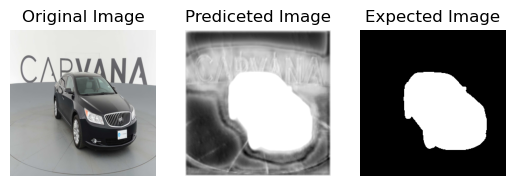

In [27]:
random_idx = torch.randint(0, len(train_X_batch), size=[1]).item()
#print(random_idx)
img_X, img_y = train_X_batch[random_idx], train_y_batch[random_idx]
predicted_image = model_1(img_X.unsqueeze(0).to(device))

fig,axes = plt.subplots(1, 3)
img_array = img_X.permute(1, 2, 0).cpu().numpy()
axes[0].imshow(img_array)
axes[0].set_title('Original Image')
axes[0].axis("Off")

img_array = predicted_image.squeeze().detach().cpu().numpy()
axes[1].imshow(img_array, cmap='gray')
axes[1].set_title('Prediceted Image')
axes[1].axis("Off")

mask_array = img_y.permute(1, 2, 0).cpu().numpy()
axes[2].imshow(mask_array, cmap="gray")
axes[2].set_title('Expected Image')
axes[2].axis("Off")

print(f"Image size: {img_X.shape}")
print(f"Masked image size: {img_y.shape}")

 *Feel free for any suggestions.*

> # **Thanks** !!!